# The comparison with commuterverses model and mean-filed approach

This notebook compares the commuterverses and mean-field approach of geographical compartment model. Although, both methods can apply arbitrary model, we use SIR model here.
The dynamical equations are given as

\begin{align}
\dot{S_{in}}	    &=-\lambda_{in}(t)S_{in}+\sigma_{in},\\
\dot{I}_{in}	    &=\lambda_{in}(t)S_{in}-\gamma_{I}I_{in},\\
\dot{R}_{in}	    &=\gamma_{I}I_{in}\\
\end{align}


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo
import pyross

import pandas as pd
import json

Firstly, the commuterverses model will be calculated.

# Generate the configuration files

### Define model

In [2]:
model = {
    "settings" : {
        "classes" : ["S", "I", "R"],
        #"stochastic_threshold_from_below" : [1000, 1000, 1000],
        #"stochastic_threshold_from_above" : [500, 500, 500],
        "contact_scaling" : "powerlaw",
        "contact_scaling_parameters" : [0, 1.0, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-betaI"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gammaI"] ],
        "infection" : [ ["I", "betaI"] ]
    },

    "R" : {
        "linear"    : [ ["I", "gammaI"] ],
        "infection" : []
    }
}

model_classes = model['settings']['classes']
model_dim = len(model_classes)

### Configuration generation parameters

Here we define some parameters with which all the configuration files will be generated. Edit these if you want to change the simulation.

In [3]:
sim_config_path = 'london_simulation'

min_num_moving = 12 # Remove all commuting edges where less than `min_num_moving` are moving

# Decide which classes are allowed to commute
allow_class = [
    ('S', True),
    ('I', True),
    ('R', True),
]

s_num=100
# Decide where to seed with infecteds
seed_pop = [
    (0, 1, 'I', s_num),      # Home, age group, model class, seed quantity
    (10, 2, 'I', s_num),      
    (23, 0, 'I', s_num),     
    (622, 4, 'I', s_num),
    (232, 4, 'I', s_num)
]

# Node parameters

n_betaI = 0.01#/1440.0
n_gammaI = 0.1/2.0

# Cnode parameters

cn_betaI = n_betaI
cn_gammaI = n_gammaI

# Time steps

t_start = 0
t_end = 24*60*100

_, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  1*60),
    (7*60,  2),
    (10*60, 2*60),
    (17*60, 2),
    (19*60, 2*60)
], end_time=24*60)

### Format the commuting network

In [4]:
cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path)

#### Set which classes are allowed to commute

# Drop the current allow_O columns
cn = cn.iloc[:,:10]

# Set allow settings
for O, allow_O in allow_class:
    cn[ "Allow %s" % O ] = 1 if allow_O else 0
    
# Allow people to return home
cn.loc[ cn['Home'] == cn['To'],"Allow %s" % allow_class[0][0]:] = 1

#### Remove commuting edges where fewer than `min_num_moving` people are commuting

delete_rows = []

for i, row in cn.loc[ cn['Home'] == cn['From'] ].iterrows():
    if row['# to move'] < min_num_moving:
        delete_rows.append(i)
        delete_rows.append(i+1) # Delete the returning commuting edge as well

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

to_move = cn["# to move"].values 
age = cn["Age"].values 
loc_home = cn["From"].values 
loc_work = cn["To"].values
t1_list = cn["t1"].values
map_commute = {}
map_index = {}

for i in range(0, len(age), 2):
    v = to_move[i]
    age_group = int(age[i]) 
    l1 = int(loc_home[i])
    l2 = int(loc_work[i])
    t1 = float(t1_list[i])
    map_commute.setdefault((age_group, l1, l2, t1), []).append(v)
    map_index.setdefault((age_group, l1, l2, t1), []).append(i)

delete_rows = []
for key in map_commute:
    if len(map_commute[key]) > 1:
        max_value = max(map_commute[key])
        v_index = map_index[key]
        for i in range(len(map_commute[key])):
            if i != map_commute[key].index(max_value):
                delete_rows.append(v_index[i])
                delete_rows.append(v_index[i]+1)
                #print(key, cn[v_index[i]:v_index[i]+1])

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

cn.loc[cn['ct1'] == cn['ct2'], 'ct2'] += 0.1

cn.head()

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow I,Allow R
0,0,0,180,5,13,-1,8.935442,9.000000,9.000000,9.166667,1,1,1
1,0,180,0,5,-1,1,17.000000,17.064558,17.064558,17.231224,1,1,1
2,0,0,185,5,19,-1,8.969720,9.000000,9.000000,9.166667,1,1,1
3,0,185,0,5,-1,1,17.000000,17.030280,17.030280,17.196947,1,1,1
4,0,0,185,6,17,-1,8.969720,9.000000,9.000000,9.166667,1,1,1


### Populate the network

Our `node_populations.csv` currently only has the total population for each age group at each node. In order to use it for the simulation, we must populate it with the model classes, as well as seed some infections.

In [5]:
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
tot_pop.head()

,Home,Location,N(0-4),N(5-10),N(11-15),N(16-24),N(25-34),N(35-49),N(50-64),N(65-74),N(75+)
0,0,0,414,601,250,910,1333,1624,1695,839,654
1,1,1,636,904,436,765,1057,1476,1036,432,550
2,2,2,845,1067,503,1094,1734,2261,1713,662,585
3,3,3,441,534,265,796,930,1113,1145,432,566
4,4,4,934,1189,562,1078,1517,2116,1404,485,397


### Setting the node and cnode parameters

We need to add rows giving the model parameters in `node_parameters.csv` and `cnode_parameters.csv`, which currently only has the areas of each geographical node:

In [6]:
# Create all model classes, and set everyone to be susceptible

npop = pd.DataFrame()
npop['Home'] = tot_pop['Home']
npop['Location'] = tot_pop['Location']

for _cn, _cd in tot_pop.iloc[:,2:].iteritems():
    for O in model['settings']['classes']:
        npop["%s%s" % (O, _cn[1:])] = 0
        
    npop["%s%s" % ("S", _cn[1:])] = _cd
    
# Seed with infecteds

for home, age, O, seed_quantity in seed_pop:
    row_i = npop[npop['Home'] == home].index[0]
    col_i = 2 + age*model_dim
    S = npop.iloc[row_i,col_i]
    npop.iloc[row_i, col_i + model_classes.index('I')] = seed_quantity
    npop.iloc[row_i, col_i] -= seed_quantity
npop

,Home,Location,S(0-4),I(0-4),R(0-4),S(5-10),I(5-10),R(5-10),S(11-15),I(11-15),...,R(35-49),S(50-64),I(50-64),R(50-64),S(65-74),I(65-74),R(65-74),S(75+),I(75+),R(75+)
0,0,0,414,0,0,501,100,0,250,0,...,0,1695,0,0,839,0,0,654,0,0
1,1,1,636,0,0,904,0,0,436,0,...,0,1036,0,0,432,0,0,550,0,0
2,2,2,845,0,0,1067,0,0,503,0,...,0,1713,0,0,662,0,0,585,0,0
3,3,3,441,0,0,534,0,0,265,0,...,0,1145,0,0,432,0,0,566,0,0
4,4,4,934,0,0,1189,0,0,562,0,...,0,1404,0,0,485,0,0,397,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,978,978,861,0,0,1012,0,0,463,0,...,0,1601,0,0,791,0,0,759,0,0
979,979,979,916,0,0,818,0,0,364,0,...,0,1008,0,0,278,0,0,139,0,0
980,980,980,1051,0,0,937,0,0,451,0,...,0,1212,0,0,404,0,0,352,0,0
981,981,981,731,0,0,726,0,0,260,0,...,0,953,0,0,408,0,0,282,0,0


In [7]:
nparam = pd.read_csv('london_simulation/node_parameters.csv')
cnparam = pd.read_csv('london_simulation/cnode_parameters.csv')
nparam.head()
cnparam.head()

,Home,From,To,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
0,ALL,ALL,ALL,ALL,1,NaN,NaN,NaN,NaN,NaN


In [8]:
cnparam['betaI'] = cn_betaI
cnparam['gammaI'] = cn_gammaI

nparam = nparam.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'Age' : 'ALL',
    'betaI' : n_betaI,
    'gammaI' : n_gammaI,
}, ignore_index=True)

nparam.iloc[-2:-1,:]

,Home,Location,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
982,982,982,ALL,1.986049,NaN,NaN,NaN,NaN,NaN


### Contact matrices

Define the contact matrices

In [9]:
C_home = np.array( [
    [5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28,4.23],
    [4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28],
    [4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33],
    [4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4],
    [4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48],
    [4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58],
    [4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69],
    [4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83],
    [4.23,4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0],
] )
    
C_school = np.array( [
    [8.0,7.83,7.69,0.25,0.19,0.15,0.12,0.1,0.09],
    [7.83,8.0,7.83,0.26,0.19,0.15,0.12,0.1,0.09],
    [7.69,7.83,8.0,0.26,0.19,0.15,0.12,0.11,0.09],
    [0.25,0.26,0.26,0.27,0.2,0.15,0.13,0.11,0.09],
    [0.19,0.19,0.19,0.2,0.2,0.16,0.13,0.11,0.09],
    [0.15,0.15,0.15,0.15,0.16,0.16,0.13,0.11,0.09],
    [0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.11,0.1],
    [0.1,0.1,0.11,0.11,0.11,0.11,0.11,0.11,0.1],
    [0.09,0.09,0.09,0.09,0.09,0.09,0.1,0.1,0.1]
])

C_work = np.array( [
    [0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07],
    [0.07,0.09,0.08,0.08,0.08,0.08,0.08,0.08,0.08],
    [0.07,0.08,0.1,0.1,0.09,0.09,0.09,0.09,0.09],
    [0.07,0.08,0.1,0.12,0.12,0.11,0.11,0.11,0.11],
    [0.07,0.08,0.09,0.12,0.15,0.15,0.14,0.14,0.14],
    [0.07,0.08,0.09,0.11,0.15,0.2,0.19,0.19,0.19],
    [0.07,0.08,0.09,0.11,0.14,0.19,6.0,5.83,5.69],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.83,6.0,5.83],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.69,5.83,6.0]
])

C_transport = np.array( [
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0]
])

CM = C_home + C_school + C_work
n_loc = 983
M = 9
data = npop.values
x0 = np.empty((2, n_loc, M)) # S, I * n_loc * M 
for mu in range(n_loc):
    for m in range(2):
        for i in range(M):
            x0[m, mu, i] = data[mu, 2+3*i+m]

populations = np.sum(x0, axis=0)
Ni = np.sum(populations, axis=0)
for i in range(M):
    for j in range(i+1,M):
        CM[j,i] = Ni[i]*CM[i,j]/Ni[j]

contact_matrices = {
    'C' : CM/1440.0, #(C_home + C_school + C_work)/1440.0,
    'C_commute' : C_transport/1440.0
}

In [10]:
ncm = pd.DataFrame(columns=['Home', 'Location'] + model['settings']['classes'])

ncm = ncm.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'I' : 'C'
}, ignore_index=True)

In [11]:
cncm = pd.DataFrame(columns=['Home', 'From', 'To'] + model['settings']['classes'])

cncm = cncm.append({
    'Home' : 'ALL',
    'From' : 'ALL',
    'To' : 'ALL',
    'I' : 'C_commute'
    #'I' : 'C'
}, ignore_index=True)

## Run simulation

In [12]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize(
    model_dat = model,
    commuter_networks_dat = cn,
    node_populations_dat = npop,
    node_parameters_dat = nparam,
    cnode_parameters_dat = cnparam,
    contact_matrices_dat = contact_matrices,
    node_cmatrices_dat = ncm,
    cnode_cmatrices_dat = cncm
)

Stochastic thresholds not defined. Will simulate deterministically.


In [13]:
sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=len(dts), steps_per_print=len(dts))

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

fij_form  1
Step 0 out of 16400
Step 164 out of 16400
Step 328 out of 16400
Step 492 out of 16400
Step 656 out of 16400
Step 820 out of 16400
Step 984 out of 16400
Step 1148 out of 16400
Step 1312 out of 16400
Step 1476 out of 16400
Step 1640 out of 16400
Step 1804 out of 16400
Step 1968 out of 16400
Step 2132 out of 16400
Step 2296 out of 16400
Step 2460 out of 16400
Step 2624 out of 16400
Step 2788 out of 16400
Step 2952 out of 16400
Step 3116 out of 16400
Step 3280 out of 16400
Step 3444 out of 16400
Step 3608 out of 16400
Step 3772 out of 16400
Step 3936 out of 16400
Step 4100 out of 16400
Step 4264 out of 16400
Step 4428 out of 16400
Step 4592 out of 16400
Step 4756 out of 16400
Step 4920 out of 16400
Step 5084 out of 16400
Step 5248 out of 16400
Step 5412 out of 16400
Step 5576 out of 16400
Step 5740 out of 16400
Step 5904 out of 16400
Step 6068 out of 16400
Step 6232 out of 16400
Step 6396 out of 16400
Step 6560 out of 16400
Step 6724 out of 16400
Step 6888 out of 16400
Step 705

## Plot the result

Plot the evolution of the whole network

/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


(0.0, 10000000.0)

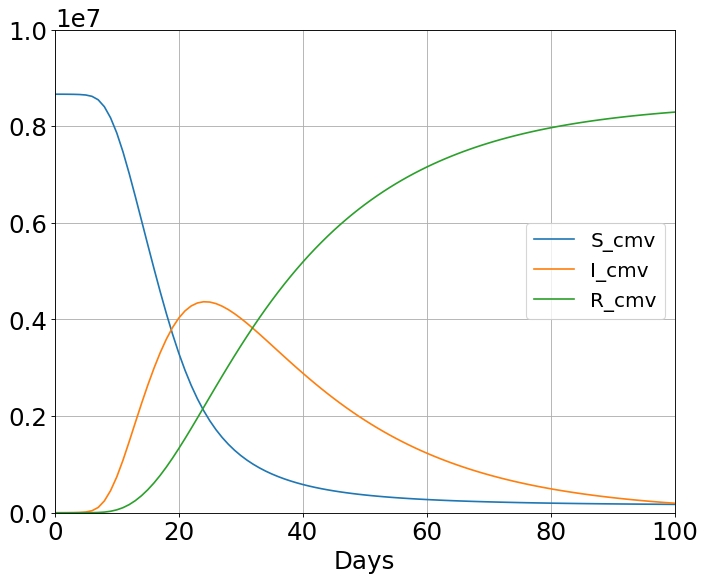

In [14]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

S = np.sum(network_data[:,:,0], axis=1)
I = np.sum(network_data[:,:,1], axis=1)
R = np.sum(network_data[:,:,2], axis=1)

plt.plot(ts_days, S, label="S_cmv")
plt.plot(ts_days, I, label="I_cmv")
plt.plot(ts_days, R, label="R_cmv")

plt.legend(loc='upper right', fontsize=12)
plt.legend(fontsize=18); plt.grid() 
plt.xlabel('Days')

ax=plt.subplot()
ax.set_xlim([0,100])
ax.set_ylim([0,10**7])

Next, we perform the mean-filed model.
The key idea of mean-field model is to note that the rate of infection of a susceptible individual in age group `i` at the node `n` is given as

\begin{align}
\lambda_{in}(t)=\lambda^0_{in}(t)=\beta\sum_{j=1}^{M}C_{ij}\frac{I_{jn}}{N^{H}_{jn}},
\end{align}


Commute can then be modeled by changing this to


\begin{align}
\lambda_{in}^{T}(t)=\beta r^{T}\sum_{j=1}^{M}\sum_{m=1}^{N_{d}} \sum_{<k,l>} C_{ij} \frac{D_{j,kl}}{N^{H}_{j,l}} \frac{I_{jl}}{N^{T}_{j,mn}} \frac{D_{i,mn}}{N^{H}_{i,n}},
\end{align}


while workplace interaction can be modeled as


\begin{align}
\lambda_{in}^{W}(t)=\beta r^{W}\sum_{j=1}^{M}\sum_{m,k=1}^{N_{d}} C_{ij} \frac{D_{j,mk}}{N^{H}_{jk}} \frac{I_{jk}}{N^{W}_{jm}}  \frac{D_{i,mn}}{N^{H}_{in}}.
\end{align}

The derivation of all equations is wrriten in [the documentation](https://github.com/lukastk/PyRossGeo/tree/master/docs/mft-model.pdf).
The simulation then runs by choosing appropriate $\lambda$ as a function of time. The constants $r_T$ and $r_W$ control the strength of interactions. In this model, we assume that each route between the nodes connectsneighbour nodes only.

The defiintion of the variables are in following.
$D_{i,nm}$ is the number of people working at node `n` and livingin `m` in the age group `i`, $N^{H}_{in}=\sum_{m} D_{i,mn}$ is the total number of residence in node `n` and $N^{W}_{in}=\sum_{m} D_{i,nm}$ is the total number of people working at node `n`.
$N_{i,nm}^{T}$ is the effective number of the commuter in the age group `i` using the route between `n` and `m`:

\begin{align}
N^{T}_{i,nm}=\sum_{<kl>}R_{i,kl}\frac{d_{kl}}{d_{nm}},
\end{align}

where $<kl>$ indicate summation of all pair of neighbour node $k$ and $l$ included in the shortest path between node 
`n` and `m` and $d_{nm}$ is the distance between node `n` and `m` along the shortest path. $R_{i,nm}=\sum_{<kl>}D_{i,kl}$ is the number of the commuter in the age group `i` using the route between the neighbor node `n` and `m`. The node `n` and `m` are included in the shortest path between node pair 
$(k,l)$ took up all combinations satisfying the conditions.
Hence, we only need $D_{i,nm}$ and $d_{nm}$ in order to construct this network model. $D_{i,nm}$ can be obtained census datasets and $d_{nm}$ can be determined by the geographical locations. For the calculation of London including 983 nodes, $D_{i,nm}$ and $d_{nm}$ are stored in census.txt and distnaces.txt, respectively.

In [15]:
import numpy as np
import pyrossgeo
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import gc

## Model Define

In [16]:
model_def = {
    "settings" : {
        "classes" : ["S", "I"],
        #"stochastic_threshold_from_below" : [1000, 1000, 1000, 1000],
        #"stochastic_threshold_from_above" : [500, 500, 500, 500],
        "contact_scaling" : "powerlaw",
        "contact_scaling_parameters" : [0, 1.0, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gI"] ],
        "infection" : [ ["I", "beta"] ] 
    }#,

    #"R" : {
    #    "linear"    : [ ["I", "gI"] ],
    #    "infection" : []
    #}
}

Loading $D_{i,nm}$ from csv files.

In [17]:
M = 9 #Aged Group

sim_config_path = 'london_simulation'
#sim_config_path = 'london_simulation'
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
#tot_pop.head()
CSV_Nh = tot_pop.values
Nd = len(tot_pop) # The number of nodes

Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
for i in range(Nd):
    for alp in range(M):
        Nh[alp,i] = CSV_Nh[i,alp + 2]

#cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path, usecols=["Home", "From", "To", "Age", "# to move"])
cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path)

# Drop the current allow_O columns
cn = cn.iloc[:,:10]

# Set allow settings
for O, allow_O in allow_class:
    cn[ "Allow %s" % O ] = 1 if allow_O else 0
    
# Allow people to return home
cn.loc[ cn['Home'] == cn['To'],"Allow %s" % allow_class[0][0]:] = 1

#### Remove commuting edges where fewer than `min_num_moving` people are commuting

delete_rows = []

for i, row in cn.loc[ cn['Home'] == cn['From'] ].iterrows():
    if row['# to move'] < min_num_moving:
        delete_rows.append(i)
        delete_rows.append(i+1) # Delete the returning commuting edge as well

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

#cn.head()
CSV_Dnm = cn.values

ii16 = np.iinfo(np.uint16)
Dnm_Max = np.amax(CSV_Dnm[:,4])
print('Max Dnm', Dnm_Max)
if ii16.max < Dnm_Max:
      print('Dnm is too large to calculate.')

to_move = cn["# to move"].values 
age = cn["Age"].values 
loc_home = cn["From"].values 
loc_work = cn["To"].values
t1_list = cn["t1"].values
map_commute = {}

census_matrix = np.zeros((M, Nd, Nd), dtype=np.uint16)
for i in range(0, len(age), 2):
    v = to_move[i]
    age_group = int(age[i]) 
    l1 = int(loc_home[i])
    l2 = int(loc_work[i])
    t1 = float(t1_list[i])
    map_commute.setdefault((age_group, l1, l2, t1), []).append(v)
    
for key in map_commute:
    census_matrix[int(key[0]), int(key[2]), int(key[1])] += max(map_commute[key])
    
for alp in range(M):
    for i in range(Nd): # Home node
        census_sum = np.sum(census_matrix[alp,:,i])
        if census_sum >  Nh[alp,i]:
            print('CHECK', alp, i, census_sum, Nh[alp,i])
        census_matrix[alp,i,i] = Nh[alp,i] - census_sum
    
df = pd.read_csv('area.csv')
Area = df.values[:,1]/10**6
        
del tot_pop
del CSV_Nh
del cn
del CSV_Dnm
del df
del map_commute
gc.collect()

Max Dnm 1064.0


283

Loading $d_{nm}$ from distances.txt

In [19]:
Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
Nw = np.zeros((M + 1,Nd)) # The number of people working in specific node.
for alp in range(M):
    for i in range(Nd):
        #Nh[alp,i] = 0.
        #Nw[alp,i] = 0.
        #for j in range(Nd):
        Nh[alp,i] = np.sum(census_matrix[alp,:,i])
        Nw[alp,i] = np.sum(census_matrix[alp,i,:])
#for alp in range(M):
for i in range(Nd):
    Nh[M,i] = np.sum(Nh[:,i]) ## N^{H}_{i} residence in Node i
    Nw[M,i] = np.sum(Nw[:,i]) ## N^{W}_{i} working in Node i
        
# set the matarix D_{nm}
Dnm = census_matrix #.copy()

# set the matarix d_{nm}
dnm = 1#distances #.copy()

max_wid = np.argsort(Nw[M])[Nd- 1]
print("Maxmimum City at Working", max_wid, Nh[M,max_wid], Nw[M,max_wid])
max_rid = np.argsort(Nh[M])[Nd- 1]
print("Maxmimum City of Residence", max_rid, Nh[M,max_rid], Nw[M,max_rid])
#sorted_Nh = np.argsort(Nh[M])
#for i in range(50):
#    print('No.', i, sorted_Nh[Nd - 1 -i], Nh[M,sorted_Nh[Nd - 1 -i]])

for i in range(M):
    print(Ni[i], np.sum(Nh[i,:]))
for i in range(Nd):
    for alp in range(M):
        if Nh[alp,i] != populations[i,alp]:
            print(i,alp,Nh[alp,i], populations[i,alp])
                
for alp in range(M):
    for i in range(Nd): # Home node
        Dnm[alp,i,i] = 0.0
        Dnm[alp,i,i] = Nh[alp,i] - np.sum(Dnm[alp,:,i])

Maxmimum City at Working 0 8320.0 243626.0
Maxmimum City of Residence 701 24719.0 23004.0
597203.0 597203.0
798582.0 798582.0
383307.0 383307.0
907943.0 907943.0
1593368.0 1593368.0
1973554.0 1973554.0
1383523.0 1383523.0
557565.0 557565.0
468230.0 468230.0


We use same $C_{ij}$, model parameters and the initial state.

In [20]:
# set the contact structure
CH = CM #C_home + C_school + C_work
CT = C_transport
CW = CM #C_home + C_school + C_work
        
# parameters, which should be inffered
beta  = 0.01/24.0       # infection rate
gI    = 0.1/2.0/24.0    # recovery rate of infectives 
rW    = 1.0             # the intercation controle in WORK
rT    = 1.0             # the intercation controle in TRANS

cutoff = 11 # We ignore D_{i,nm}, when It is less than the vule of cutoff.
trv_restriction = 0.0   # travel restriction: 1.0 means everyone stay home

max_wid = np.argsort(Nw[M])[Nd- 1]
#print("Maxmimum City at Working", max_wid)
max_rid = np.argsort(Nh[M])[Nd- 1]
#print("Maxmimum City of Residence", max_rid)
min_wid = np.argsort(Nw[M])[0]
#print("Minimum City at Working", min_wid)
min_rid = np.argsort(Nh[M])[0]
#print("Minimum City of Residence", min_rid)

M1 = Nd*M
I_0 = np.zeros((M1))

#seed_pop = [
#    (0, 1, 'E', 100),      # Home, age group, model class, seed quantity
#    (10, 2, 'E', 100),      
#    (23, 0, 'E', 100),     
#    (622, 4, 'E', 100),
#    (232, 4, 'E', 100)
#]
s_num = 100
I_0[1*Nd + 0]   += s_num
I_0[2*Nd + 10]  += s_num
I_0[0*Nd + 23]  += s_num
I_0[4*Nd + 622] += s_num
I_0[4*Nd + 232] += s_num

#Is_0[min_wid] += 10
R_0 = np.zeros((M1))
N_0 = np.zeros((M1))
for alp in range(M):
    for i in range(Nd):
        N_0[Nd*alp + i] = Nh[alp,i]
S_0  = N_0 - (I_0 + R_0)
print("Maximum R", max_rid, Nh[M,max_rid], Nw[M,max_rid])
print("Maximum w", max_wid, Nh[M,max_wid], Nw[M,max_wid])
print("Minimum R", min_rid, Nh[M,min_rid], Nw[M,min_rid])
print("Minimum w", min_wid, Nh[M,min_wid], Nw[M,min_wid])

# the contact matrix
def contactMatrix(t):
    t_p_24 = t%24
    if t_p_24 < 8.0 or t_p_24 > 18.0:
        return CH
    elif t_p_24 > 9.0 and t_p_24 < 17.0:
        return CW
    else:
        return CT

# set the matarix D_{nm}
#Dnm = census_matrix.copy()

# set the matarix d_{nm}
#dnm = distances.copy()

# instantiate model
#geographical_model = 'RapidTransport'
geographical_model = 'SpacialCompartment'
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.MeanFieldTheory(geographical_model, model_def, parameters, M, Nd, Dnm, dnm, Area, trv_restriction, cutoff, fij_form=0)

Maximum R 701 24719.0 23004.0
Maximum w 0 8320.0 243626.0
Minimum R 665 5031.0 4683.0
Minimum w 370 5717.0 3817.0
{'S': 0, 'I': 1}
#Start to calculate fixed variables
Nonzero element 47349/78269409 8663275.0
Max index J 975
Max index I 49
#Finish calculating fixed variables
contact scaling powerlaw


After setting the parameters, the calculation of network model will be started. **The modern laptop can finish this calculation about 5 second.**

In [21]:
#beta  = 0.020/24.0
rW=1.0

# intialize the model
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model.initialize(model_def, parameters, trv_restriction)

# duration of simulation
Tf=24*100; Nf=0.25*Tf # Maximum time step equals as Tf/Nf
Nf=(1.0/48.0)*Tf # Spacial Compartment Model 
# simulate model
data_rtm=model.simulate(np.concatenate((S_0, I_0)), contactMatrix, Tf, Nf, Ti=0, method='RK23')

{'S': 0, 'I': 1}
#Start to calculate fixed variables
Nonzero element 47349/78269409 8663275.0
Max index J 975
Max index I 49
#Finish calculating fixed variables
SpacialCompartment 0
travel restriction 0.0
cutoff 11.0
highspeed 0
#Calculation Start
Numerical Integrate RK23
Time 102.8349746148936
Time 200.2836440269407
Time 303.166066636041
Time 402.1393958984595
Time 503.76258927974055
Time 605.4611161188406
Time 700.2933188628687
Time 801.1626033766953
Time 917.9082140983107
Time 1004.5155997181574
Time 1103.9521892311604
Time 1223.9521892311604
Time 1319.9521892311604
Time 1415.9521892311604
Time 1511.9521892311604
Time 1607.9521892311604
Time 1703.9521892311604
Time 1811.9521892311604
Time 1907.9521892311604
Time 2003.9521892311604
Time 2111.9521892311604
Time 2207.9521892311604
Time 2303.9521892311604
Time 2400.0


Loading the results.

In [22]:
S_RTM = []
I_RTM = []

for i in range(Nd*M):
    S_RTM.append(data_rtm.get('X')[i].flatten())
    I_RTM.append(data_rtm.get('X')[i + 1*M1].flatten())
t_rtm = data_rtm['t']

rtm_community_data = np.zeros((len(t_rtm), M, 3, Nd))
for tt in range(len(t_rtm)):
    for i in range(M):
        for n in range(Nd):
            rtm_community_data[tt, i, 0, n] = S_RTM[i*Nd + n][tt]
            rtm_community_data[tt, i, 1, n] = I_RTM[i*Nd + n][tt]
            rtm_community_data[tt, i, 2, n] = Nh[i,n] - (S_RTM[i*Nd + n][tt] + I_RTM[i*Nd + n][tt])

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

## Setting parameters and the calculation for Spacial Compartment Model

In [23]:
# instantiate model
rW=1.0
geographical_model = 'SpacialCompartment'
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.MeanFieldTheory(geographical_model, model_def, parameters, M, Nd, Dnm, dnm, Area, trv_restriction, cutoff, fij_form=1)

# duration of simulation
Tf=24*100; Nf=(1.0/48.0)*Tf # Spacial Compartment Model #Maximum time step equals as Tf/Nf
# simulate model
data=model.simulate(np.concatenate((S_0, I_0)), contactMatrix, Tf, Nf, Ti=0, method='RK23')

{'S': 0, 'I': 1}
#Start to calculate fixed variables
Nonzero element 47349/78269409 8663275.0
Max index J 975
Max index I 49
#Finish calculating fixed variables
contact scaling powerlaw
SpacialCompartment 1
travel restriction 0.0
cutoff 11.0
highspeed 0
#Calculation Start
Numerical Integrate RK23
Time 100.51117129292074
Time 202.74405866770022
Time 302.8733612773637
Time 401.5491709175252
Time 503.18568062621966
Time 601.7815305906772
Time 700.7495051282776
Time 802.4146595514288
Time 907.1617088914172
Time 1012.8375454702809
Time 1107.9472815036695
Time 1203.9472815036695
Time 1311.9472815036695
Time 1407.9472815036695
Time 1503.9472815036695
Time 1611.9472815036695
Time 1707.9472815036695
Time 1803.9472815036695
Time 1923.9472815036695
Time 2019.9472815036695
Time 2115.9472815036697
Time 2211.9472815036697
Time 2307.9472815036697
Time 2400.0


Loading the results of spacial compartment model

In [24]:
S_SCM = []
I_SCM = []

for i in range(Nd*M):
    S_SCM.append(data.get('X')[i].flatten())
    I_SCM.append(data.get('X')[i + 1*M1].flatten())
t_scm = data['t']

scm_community_data = np.zeros((len(t_scm), M, 3, Nd))
for tt in range(len(t_scm)):
    for i in range(M):
        for n in range(Nd):
            scm_community_data[tt, i, 0, n] = S_SCM[i*Nd + n][tt]
            scm_community_data[tt, i, 1, n] = I_SCM[i*Nd + n][tt]
            scm_community_data[tt, i, 2, n] = Nh[i,n] - (S_SCM[i*Nd + n][tt] + I_SCM[i*Nd + n][tt])

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

## Plotting the results

/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


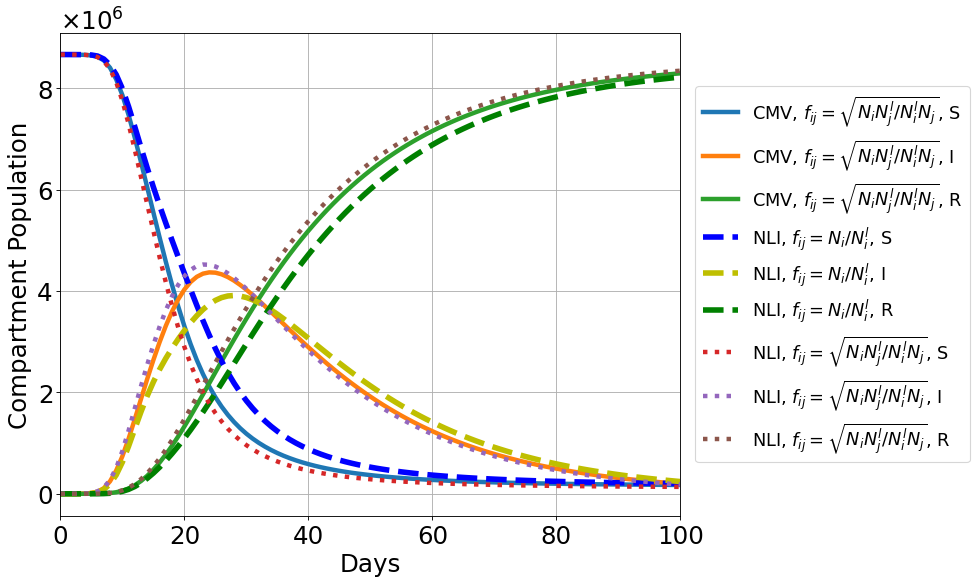

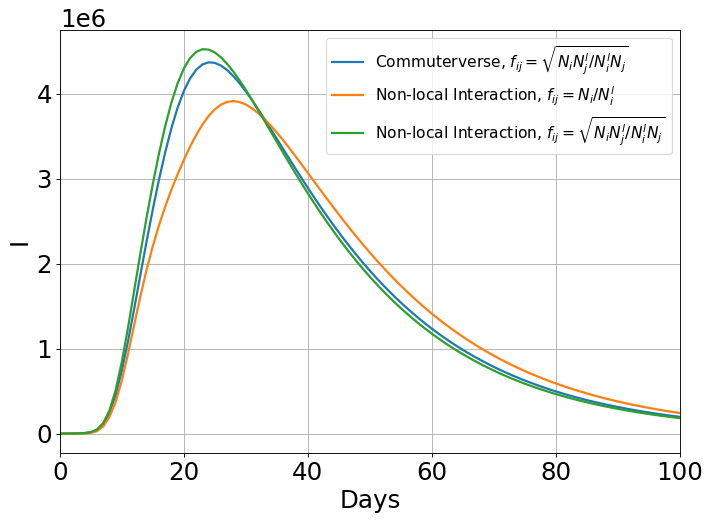

In [43]:
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nd):
    total_w += Nw[M][i]
    total_r += Nh[M][i]
#print('Toatl', total_w, total_r)

S_total = []
I_total = []
for i in range(len(S_RTM[0])):
    S_total.append(0.0)
    I_total.append(0.0)
for i in range(M1):
    S_total  += S_RTM[i]
    I_total  += I_RTM[i]
    
S_total2 = []
I_total2 = []
for i in range(len(S_RTM[0])):
    S_total2.append(0.0)
    I_total2.append(0.0)
for i in range(M1):
    S_total2  += S_SCM[i]
    I_total2  += I_SCM[i]
fij_1 = '$f_{ij}=\sqrt{N_{i}N_{j}^{l}/N_{i}^{l}N_{j}}$'
fij_0 = '$f_{ij}=N_{i}/N_{i}^{l}$'
fij_C = fij_S
plt.plot(ts_days, S, label="CMV, " + fij_1 + ", S", lw=4)
plt.plot(ts_days, I, label="CMV, " + fij_1 + ", I", lw=4)
plt.plot(ts_days, R, label="CMV, " + fij_1 + ", R", lw=4)

plt.plot(t_rtm/24, S_total, label='NLI, ' + fij_0 + ', S', lw=5, linestyle='dashed', color='b')
plt.plot(t_rtm/24, I_total, label='NLI, ' + fij_0 + ', I', lw=5, linestyle='dashed', color='y')
plt.plot(t_rtm/24, total_r - S_total - I_total, label='NLI, ' + fij_0 + ', R', lw=5, linestyle='dashed', color='g')

plt.plot(t_scm/24, S_total2, label='NLI, ' + fij_1 + ', S', lw=4, linestyle='dotted')
plt.plot(t_scm/24, I_total2, label='NLI, ' + fij_1 + ', I', lw=4, linestyle='dotted')
plt.plot(t_scm/24, total_r - S_total2 - I_total2, label='NLI, ' + fij_1 + ', R', lw=4, linestyle='dotted')

plt.xlabel('Days')
plt.ylabel('Compartment Population')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=16); plt.grid() 
#plt.autoscale(enable=True, axis='x', tight=True)

ax=plt.subplot()
#ax.grid(which="both")
#ax.set_xlabel("x")
#ax.set_ylabel("y")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax.set_xlim([0,100])
#ax.set_ylim([0,2.0*10**1])
fig.savefig("London_EpidemicCurve-CVM-NLI_SIR.png")

f_data = open('network-SIR-MFT.txt', mode='w')
for i in range(len(t_rtm)):
    f_data.write(str(t_rtm[i]/24) + ' ' + str(S_total[i]) + ' ' + str(I_total[i]) + '\n')
f_data.close()

fig = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nd):
    total_w += Nw[M,i]
    total_r += Nh[M,i]
#print('Toatl', total_w, total_r)

RTM_total = []
SCM_total = []
for i in range(len(S_SCM[0])):
    RTM_total.append(0.0)
    SCM_total.append(0.0)
for i in range(M1):
    RTM_total  += I_RTM[i]
    SCM_total  += I_SCM[i]

plt.plot(ts_days, I, label="Commuterverse, " + fij_1, lw = 2)
plt.plot(t_rtm/24, RTM_total, '-', label='Non-local Interaction, ' + fij_0, lw=2)
plt.plot(t_scm/24, SCM_total, '-', label='Non-local Interaction, ' + fij_1, lw=2)
plt.legend(fontsize=14); plt.grid() 
plt.xlabel('Days')
plt.ylabel('I')
ax=plt.subplot()
ax.set_xlim([0,100])
fig.savefig("London_I-CVM-RTM-SCM.png")

## Spacial distibution of S,I and R

In [26]:
import pickle
import tempfile
#import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
from matplotlib import animation

# Simulation data


N_ = np.zeros((len(t_rtm), Nd))
for tt in range(len(t_rtm)):
        for n in range(Nd):
            N_[tt, n] = Nh[M,n]

#Commuteverse 
S_CVM_ = np.sum(community_data[:,:,0,:], axis=1)
I_CVM_ = np.sum(community_data[:,:,1,:], axis=1)
R_CVM_ = np.sum(community_data[:,:,2,:], axis=1)

s_cvm_ = S_CVM_ / N_
i_cvm_ = I_CVM_ / N_
r_cvm_ = R_CVM_ / N_

#Rapid Transport
S_RTM_ = np.sum(rtm_community_data[:,:,0,:], axis=1)
I_RTM_ = np.sum(rtm_community_data[:,:,1,:], axis=1)
R_RTM_ = np.sum(rtm_community_data[:,:,2,:], axis=1)

s_rtm_ = S_RTM_ / N_
i_rtm_ = I_RTM_ / N_
r_rtm_ = R_RTM_ / N_

#Spacial Compartment
S_SCM_ = np.sum(scm_community_data[:,:,0,:], axis=1)
I_SCM_ = np.sum(scm_community_data[:,:,1,:], axis=1)
R_SCM_ = np.sum(scm_community_data[:,:,2,:], axis=1)

s_scm_ = S_SCM_ / N_
i_scm_ = I_SCM_ / N_
r_scm_ = R_SCM_ / N_

ts_days = t_rtm/24

# Load geometry

geometry_node_key = 'msoa11cd'
geometry = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")

loc_table = pd.read_csv('london_simulation/loc_table.csv')
loc_table_loc_col = loc_table.columns[0]
loc_table_loc_key_col = loc_table.columns[1]

geometry = geometry[ geometry[geometry_node_key].isin(loc_table.iloc[:,1]) ] # Remove locations in geometry that are not in loc_table
geometry = geometry.merge(loc_table, left_on=geometry_node_key, right_on=loc_table_loc_key_col) # Add location indices
geometry = geometry.sort_values(by=loc_table_loc_col) # Sort them by location indices

# Edit this function to adjust the layout of the video

def plot_frame(ti, close_plot=False, tmp_save=None):
    fig, axes = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios':[1, 1, 1.3]}, figsize=(18, 14))

    geometry['S'] = s_[ti,:]
    geometry['I'] = i_[ti,:]
    geometry['R'] = r_[ti,:]
    
    plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='S', title="Susceptible", legend=False)
    plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='I', title="Infected", legend=False)
    plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R', title="Recovered", legend=False)
    
    plot_epi(axes[1,2], ti, ts_days, epi_data, ['S','I','R'])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("SEAIR Model - Day %s" % ti, fontsize=18)
    
    if not tmp_save is None:
        plt.savefig(tmp_save.name + '/%s.png' % ti)
    if close_plot:
        plt.close(fig)
    if not tmp_save is None:
        return tmp_save.name + '/%s.png' % ti

# Helper functions for plotting

def plot_geo(geometry, ax, vmin, vmax, value_key='val', title="", legend=True, legend_label='', cax=None, axis_on=False):
    if legend:
        if cax is None:
            geometry.plot(column=value_key, ax=ax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
        else:
            geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
    else:
        geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=False)
        
    ax.set_title(title)
    if not axis_on:
        ax.set_axis_off()
        
def plot_epi(ax, ti, ts, epi_data, epi_data_labels):
    for oi in range(epi_data.shape[0]):
        ax.plot(ts[:ti], epi_data[oi,:ti], label=epi_data_labels[oi])
    ax.legend(loc='center left')
    
    ax.set_xlim(np.min(ts_days), np.max(ts_days))
    ax.set_ylim(0, np.max(epi_data))

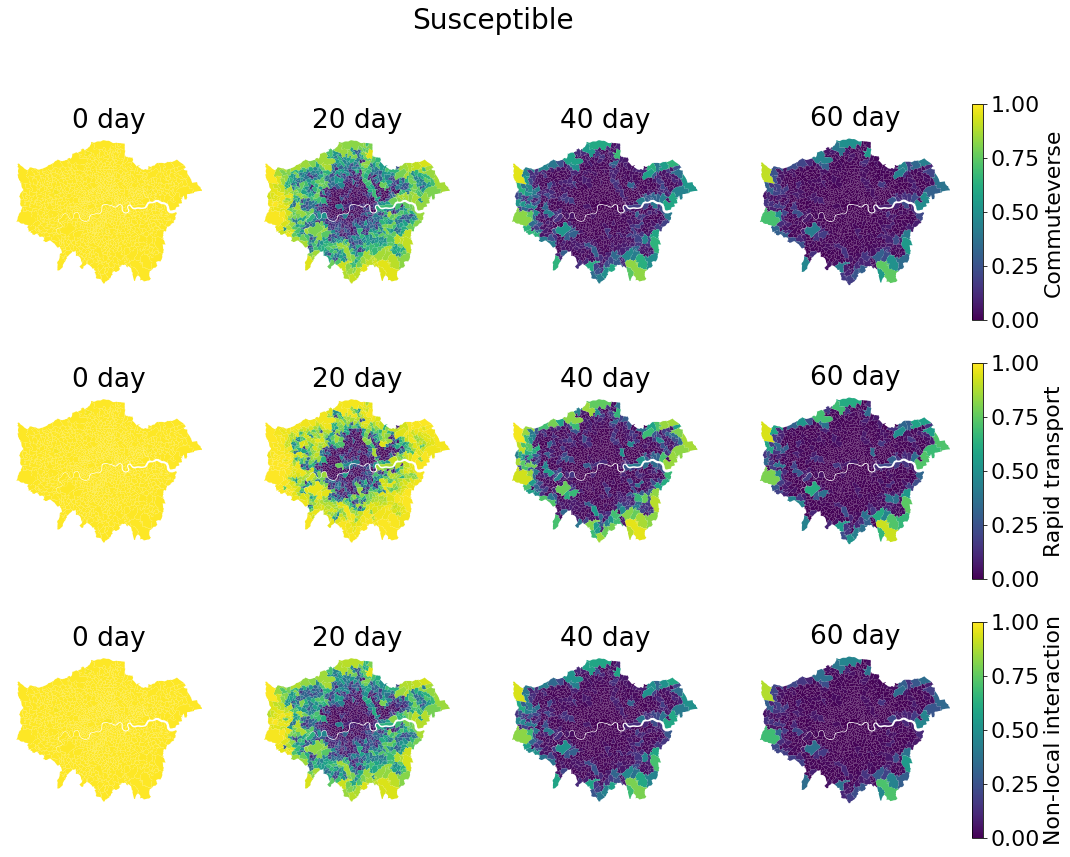

In [27]:
fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.28]}, figsize=(18, 13.5))

fig.suptitle('Susceptible', fontsize=28)

dday = 20

geometry['C0']  = s_cvm_[0*dday,:]
geometry['C10'] = s_cvm_[1*dday,:]
geometry['C20'] = s_cvm_[2*dday,:]
geometry['C30'] = s_cvm_[3*dday,:]

geometry['R0']  = s_rtm_[0*dday,:]
geometry['R10'] = s_rtm_[1*dday,:]
geometry['R20'] = s_rtm_[2*dday,:]
geometry['R30'] = s_rtm_[3*dday,:]

geometry['S0']  = s_scm_[0*dday,:]
geometry['S10'] = s_scm_[1*dday,:]
geometry['S20'] = s_scm_[2*dday,:]
geometry['S30'] = s_scm_[3*dday,:]

plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='C0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='C10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='C20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='C30', title='%s day' % (3*dday), legend=True, legend_label='Commuteverse')
plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='S0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='S10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2,2], vmin=0, vmax=1, value_key='S20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[2,3], vmin=0, vmax=1, value_key='S30', title='%s day' % (3*dday), legend=True, legend_label='Non-local interaction')
fig.savefig('Susceptible.png')

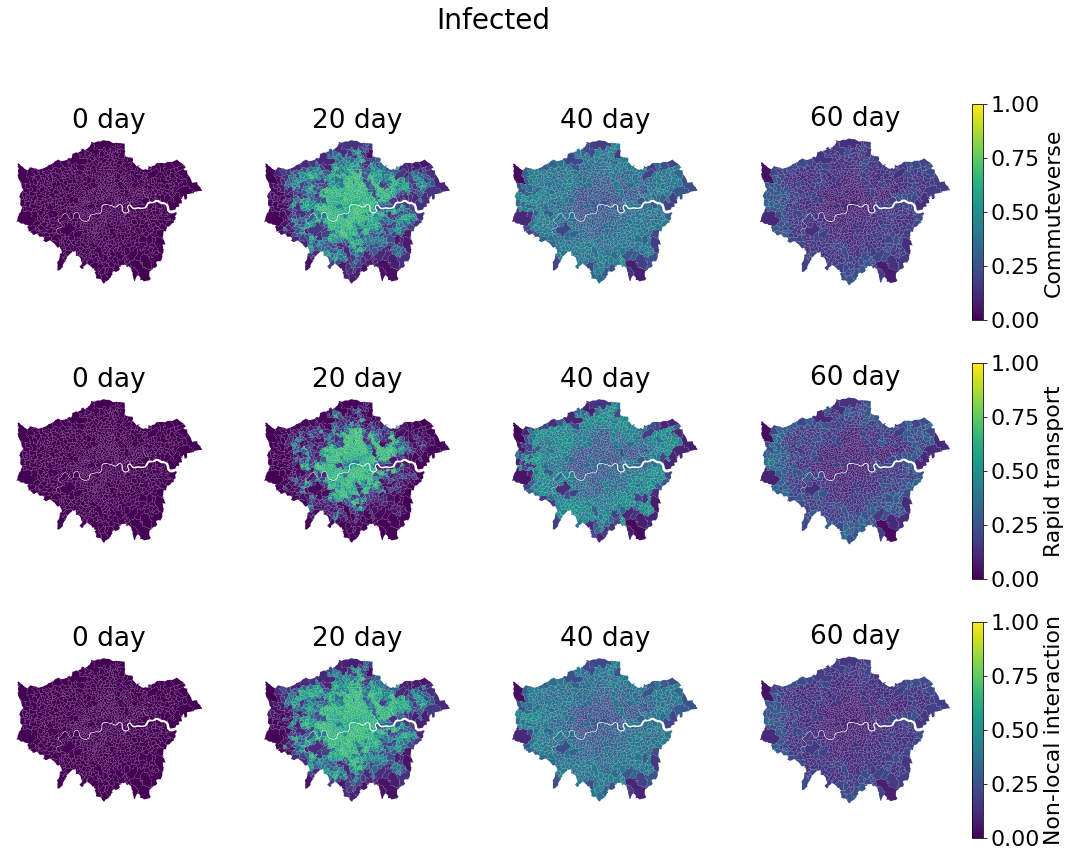

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.28]}, figsize=(18, 13.5))

fig.suptitle('Infected', fontsize=28)

geometry['C0']  = i_cvm_[0*dday,:]
geometry['C10'] = i_cvm_[1*dday,:]
geometry['C20'] = i_cvm_[2*dday,:]
geometry['C30'] = i_cvm_[3*dday,:]

geometry['R0']  = i_rtm_[0*dday,:]
geometry['R10'] = i_rtm_[1*dday,:]
geometry['R20'] = i_rtm_[2*dday,:]
geometry['R30'] = i_rtm_[3*dday,:]

geometry['S0']  = i_scm_[0*dday,:]
geometry['S10'] = i_scm_[1*dday,:]
geometry['S20'] = i_scm_[2*dday,:]
geometry['S30'] = i_scm_[3*dday,:]

plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='C0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='C10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='C20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='C30', title='%s day' % (3*dday), legend=True, legend_label='Commuteverse')
plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='S0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='S10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2,2], vmin=0, vmax=1, value_key='S20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[2,3], vmin=0, vmax=1, value_key='S30', title='%s day' % (3*dday), legend=True, legend_label='Non-local interaction')
fig.savefig('Infection.png')

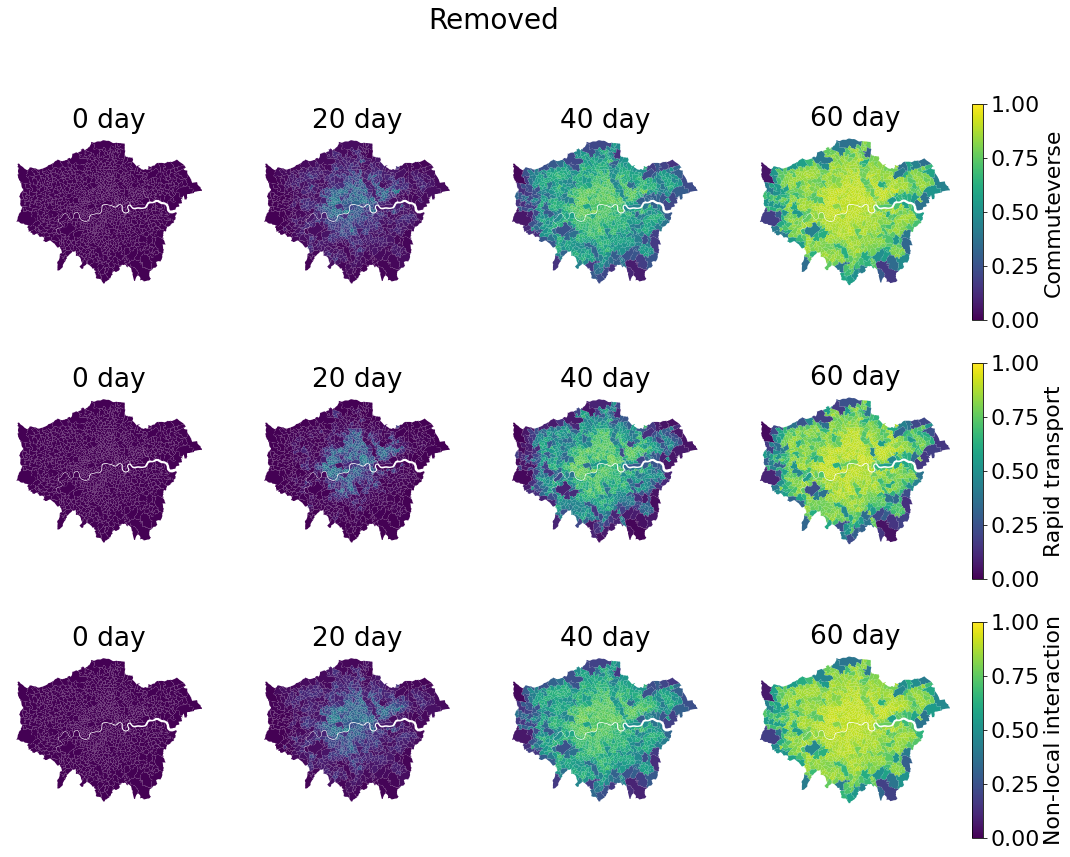

In [29]:
fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.28]}, figsize=(18, 13.5))

fig.suptitle('Removed', fontsize=28)

geometry['C0']  = r_cvm_[0*dday,:]
geometry['C10'] = r_cvm_[1*dday,:]
geometry['C20'] = r_cvm_[2*dday,:]
geometry['C30'] = r_cvm_[3*dday,:]

geometry['R0']  = r_rtm_[0*dday,:]
geometry['R10'] = r_rtm_[1*dday,:]
geometry['R20'] = r_rtm_[2*dday,:]
geometry['R30'] = r_rtm_[3*dday,:]

geometry['S0']  = r_scm_[0*dday,:]
geometry['S10'] = r_scm_[1*dday,:]
geometry['S20'] = r_scm_[2*dday,:]
geometry['S30'] = r_scm_[3*dday,:]

plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='C0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='C10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='C20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='C30', title='%s day' % (3*dday), legend=True, legend_label='Commuteverse')
plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='S0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='S10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2,2], vmin=0, vmax=1, value_key='S20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[2,3], vmin=0, vmax=1, value_key='S30', title='%s day' % (3*dday), legend=True, legend_label='Non-local interaction')
fig.savefig('Removed.png')